In [12]:
import sys; sys.path.append('/rds/general/user/cb2714/home/wwa/'); from wwa import *

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/"

In [2]:
rnm = "socal-baja"
sf = gpd.read_file("sf_socal-baja/").to_crs(epsg = 4326)

Xn, Xx, Yn, Yx = [-125,-110,30,40]   # larger box for extracting data
xn, xx, yn, yx = [-121,-116,32,35]   # extent for figures

la = [-118.24, 34.05]

mapproj = cartopy.crs.PlateCarree()

states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.to_geodataframe().clip((xn,yn,xx,yx))



days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

/rds/general/user/cb2714/home/anaconda3/envs/wwa_xesmf/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


# Physical geography

In [65]:
elev = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data).sel(lon = slice(xn,xx), lat = slice(yn,yx))

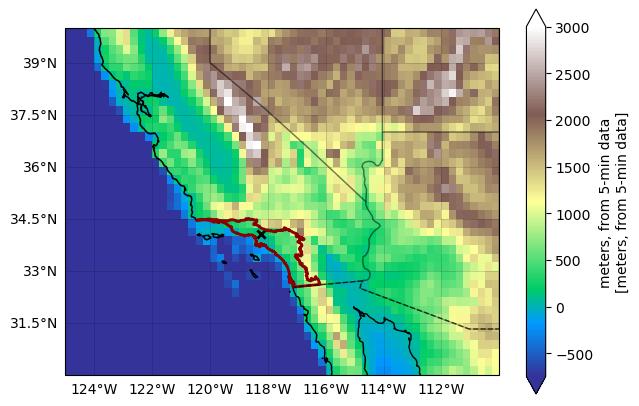

In [67]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : mapproj})

elev.plot(ax = ax, cmap = "terrain", vmin = -750, vmax = 3000)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
ax.coastlines()

# gacc.boundary.plot(ax = ax, color = "firebrick", lw = 2, ls = "--")
sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
ax.scatter(*la, marker = "x", color = "k", lw = 2)

# Event maps

## FWI (MSWX)

In [3]:
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/mswx/fwi_mswx_2024-2025.nc")
da = da.sel(time = slice("2025-01-07", None))

vcols = {"dc" : "Oranges", "dmc" : "Oranges", "ffmc" : "Oranges", "isi" : "Oranges", "bui" : "Oranges", "fwi" : "Oranges"}
vmaxes = {"dc" : 2500, "dmc" : 1500, "ffmc": 100, "isi" : 500, "bui" : 1500, "fwi" : 500}

In [20]:
for varnm in vcols.keys():

    fig = da[varnm].plot(col = "time", col_wrap = 4, figsize = (18,6), subplot_kws = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)}, cmap = vcols[varnm], vmin = 0, vmax = vmaxes[varnm],
                                            cbar_kwargs = {"fraction" : 0.025, "pad" : 0.01, "shrink" : 0.85}, sharex = True, sharey = True)
    plt.suptitle(varnm, fontweight = "bold")

    for ax in fig.axs.flat:
        ax.coastlines()
        sf.boundary.plot(ax = ax, color = "darkblue")
        ax.scatter(*la, marker = "x", color = "k", lw = 2)
        states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
        ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

    plt.savefig("/rds/general/user/cb2714/home/wwa/25-01_california-wildfires/fig/event-map_"+varnm+"-2025_mswx.png"); plt.close()

# 2024-5 vs previous years

In [4]:
days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

In [6]:
ds = "mswx"

for varnm in ["pr", "dc", "dmc", "ffmc", "bui", "isi", "fwi", "dsr", "fwimax", "fwiq95", "tas", "hurs", "sfcWind", "hdwi", "hdwimax"]:
    
    fnm = "data/"+ds+"_"+varnm+"_"+rnm+".nc"
    if not os.path.exists(fnm): continue
        
    ts = xr.open_dataset(fnm)[varnm]
    ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 181).data))

    fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100, sharex = True, sharey = True)
    axs = [axs]

    for i in range(1):

        ax = axs[i]

        for y in range(1991,2020):
            ts_y = ts.sel(time = ts.offset_time.dt.year == y)
            ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

        y = 1991; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3, label = "1991-2020")
    #     y = 2023; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "darkblue", label = "2024-2025")
        y = 2024; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2024-2025")

        ax.legend()
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        [ax.axvline(x, color = "k", alpha = 0.05) for x in range(365) if (days[x].day) == 1]

        ax.set_title(varnm)

    plt.savefig("fig/daily-ts_"+varnm+"_"+ds+".png"); plt.close()

## 2024-25 vs climatology

In [34]:
varnm = "pr"
ts = xr.open_dataset("data/era5_"+varnm+"_"+rnm+".nc")[varnm]
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 181).data))

mmean = ts.sel(time = slice("1990","2020")).groupby("offset_time.month").mean()
msd = ts.sel(time = slice("1990","2020")).groupby("offset_time.month").std()
m_upper = mmean+msd
m_lower = mmean-msd

y2024 = ts.sel(time = ts.offset_time.dt.year == 2024).groupby("offset_time.month").mean()

In [37]:
fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100, sharex = True, sharey = True)
axs = [axs]

for i in range(1):
    
    ax = axs[i]
    ax.bar(mmean.month, mmean, color = "cornflowerblue", edgecolor = "k", alpha = 0.75)
    
    for m in range(12):
        ax.plot([m+1,m+1], [m_lower.sel(month = m+1), m_upper.sel(month = m+1)], color = "k", alpha = 0.3, marker = "_", solid_capstyle = "butt")
        
    ax.plot(y2024.month, y2024, marker = ".", ls = "", color = "k", label = "2024")
        
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(list(range(7,13)) + list(range(1,7)))
    ax.set_ylim(0)

---
# Onset of rainy season

## WA drought definition

In [39]:
# methods used to identify onset of rainy season in the West Africa drought study
from xclim.indices.run_length import rle

def anom_diff_ts(ts, sm = 15, t_0 = 0):
    
    # t_0 is start of year used for accumulation of anomalies (should be in middle of dry season - default is to start from beginning of calendar year)
    # sm is number of days used to smooth the anomalies (default is 15, ie day +- 7 days)
    
    # wrap year at t_0 by shifting all values forwards
    ts = ts.shift(time = -t_0)
    
    # daily anomaly wrt annual mean
    anom = ts.groupby("time.year") - ts.groupby("time.year").mean("time")
       
    # cumulative daily anomalies each year
    anom_cum = anom.groupby("time.year").cumsum()
    
    # smooth the cumulative anomalies
    anom_sm = anom_cum.rolling(time = sm, center = True).mean()
    
    # differences of smoothed anomalies
    anom_diff = anom_sm.diff("time")
    
    # push the anomalies back to have the correct dates
    anom_diff = anom_diff.shift(time = t_0)
    
    return anom_diff


def rainy_season(ts, sm = 15, t_0 = 0):
        
    # get differences of smoothed anomalies
    anom_ts = anom_diff_ts(ts, sm = sm, t_0 = t_0)
    
    # count number of consecutive days of positive gradient in cumulative precip
    rs_length = rle(xr.ones_like(anom_ts).where(anom_ts > 0, 0))
    
    # tag all days with length of period to which they belong
    rs_length = rs_length.ffill("time")
    
    # identify those days that are part of the longest wet period in each year
    rs = rs_length.where(rs_length.groupby("time.year") - rs_length.groupby("time.year").max() == 0)
        
    # convert calendar to Gregorian, matching dates (ensures that DOY is correct, regardless of model calendar)
    rs = convert_calendar(rs, "default", align_on = "date")
    
    # get start & end of rainy season
    onsets = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").min().dt.dayofyear
    ends = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").max().dt.dayofyear
    
    # duration of rainy season
    durations = ends - onsets
    
    return onsets, ends, durations

In [40]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr

In [41]:
onsets, ends, durations = rainy_season(pr, sm = 5, t_0 =  183)

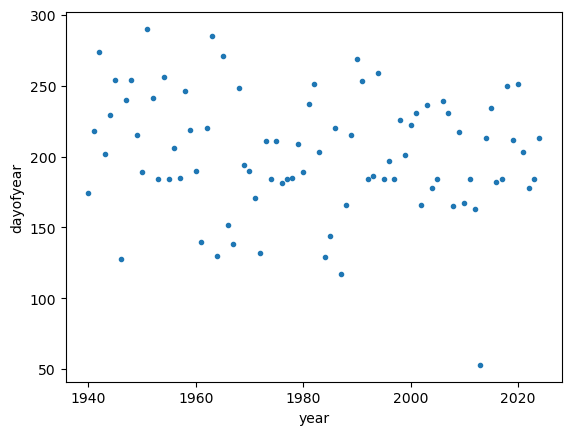

In [49]:
((onsets + 183) % 365).plot(marker = ".", ls = "")

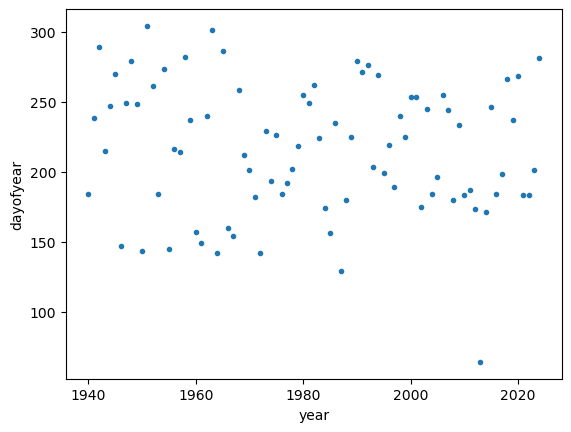

In [50]:
((ends+ 183) % 365).plot(marker = ".", ls = "")

## Daniel Swain's suggestion

Rainy season starts after a certain amount of precip has accumulated

In [111]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr
pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = 181).data))

In [112]:
pr_rscum = pr.resample(time = "AS-JUL").cumsum().assign_coords(time = pr.time)

In [148]:
rs_onset100 = pr_rscum.offset_time.where(pr_rscum >= 100).dropna("time", "any").resample(time = "AS-JUL").min()
rs_onset50 = pr_rscum.offset_time.where(pr_rscum >= 50).dropna("time", "any").resample(time = "AS-JUL").min()
rs_onset25 = pr_rscum.offset_time.where(pr_rscum >= 25).dropna("time", "any").resample(time = "AS-JUL").min()
rs_onset10 = pr_rscum.offset_time.where(pr_rscum >= 10).dropna("time", "any").resample(time = "AS-JUL").min()

Text(0.5, 0.98, 'Number of days after July 1st to exceed specified threshold ')

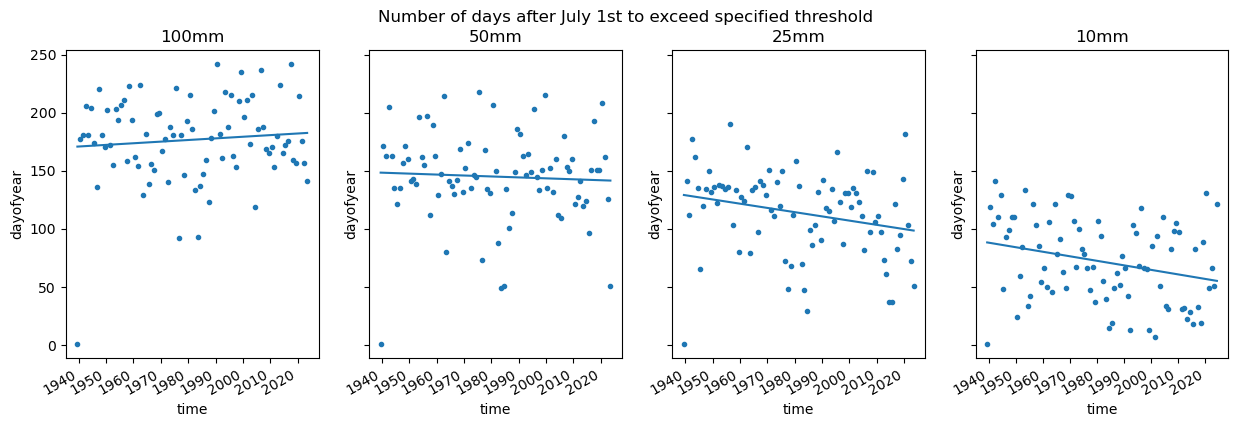

In [153]:
nc = 4
fig, axs = plt.subplots(ncols = nc, figsize = (15,4), dpi = 100, sharey = True)

for i in range(nc):
    ax = axs[i]
        
    rs_onset = [rs_onset100, rs_onset50, rs_onset25, rs_onset10][i]
    rs_onset.dt.dayofyear.plot(ax = ax, marker = ".", ls = "")
    ax.plot(rs_onset.time, np.poly1d(np.polyfit(rs_onset.time.dt.year, rs_onset.dt.dayofyear, 1))(np.sort(rs_onset.time.dt.year)), color = "tab:blue")
    
    ax.set_title(["100mm", "50mm", "25mm", "10mm"][i])
plt.suptitle("Number of days after July 1st to exceed specified threshold ")

## Theo's suggestion

Rainy season starts after a certain amount of precip has accumulated